In [1]:
import sys, os
sys.path.append('/Users/ajc/Core/codes/simulator/debug/ats-mesh/tools/meshing_ats/meshing_ats')
#sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats','meshing_ats'))
import meshing_ats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
"""
infile = "vtks/watershed.vtk".encode('utf8')
outfile = "/meshes/watershed-barrow/"
#Ray
infile = "vtks/final_mesh_100m_2000m_vtk.vtk".encode('utf8')
outfile = "/meshes/"
#m2 = meshing_ats.Mesh2D.read_VTK(infile)
m2 =meshing_ats.Mesh2D.read_VTK_Unstructured(infile)
"""

'\ninfile = "vtks/watershed.vtk".encode(\'utf8\')\noutfile = "/meshes/watershed-barrow/"\n#Ray\ninfile = "vtks/final_mesh_100m_2000m_vtk.vtk".encode(\'utf8\')\noutfile = "/meshes/"\n#m2 = meshing_ats.Mesh2D.read_VTK(infile)\nm2 =meshing_ats.Mesh2D.read_VTK_Unstructured(infile)\n'

In [21]:
name='sp_1km_6pc'
infile = ("/Users/ajc/Core/PyScript/meshes/watershed_synthetic/vtks/%s.vtk"%name).encode('utf8')
outfile = "/meshes/watershed-barrow/"
#Ray
#infile = "vtks/final_mesh_100m_2000m_vtk.vtk".encode('utf8')
#outfile = "/meshes/"
#m2 = meshing_ats.Mesh2D.read_VTK(infile)
m2 =meshing_ats.Mesh2D.read_VTK_Unstructured(infile)

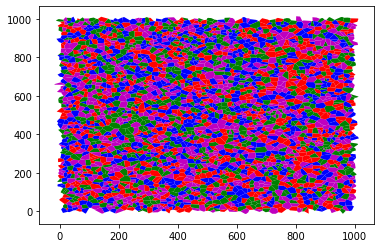

In [22]:
m2.plot(color=['b','r','g','m','c'])
plt.show()

In [23]:
"""
path = '/Users/ajc/research/PreProcessing/python-scripts/meshes/watershed-barrow/'
def read_poly_ids():
    ids = []
    with open(os.path.join(path,'poly_char_gids/manually_char_polygons_new.txt')) as f:
        for line in f:
            if 'Zone:' in line:
                c = int(line.split()[1])
                if not c in ids:
                    ids.append(c)
    return ids

IDS2= read_poly_ids()
#id1=np.sort(IDS1)
hcp_gids=np.sort(IDS2)
#print (id1, hcp_gids)
print (len(hcp_gids),hcp_gids)
"""

"\npath = '/Users/ajc/research/PreProcessing/python-scripts/meshes/watershed-barrow/'\ndef read_poly_ids():\n    ids = []\n    with open(os.path.join(path,'poly_char_gids/manually_char_polygons_new.txt')) as f:\n        for line in f:\n            if 'Zone:' in line:\n                c = int(line.split()[1])\n                if not c in ids:\n                    ids.append(c)\n    return ids\n\nIDS2= read_poly_ids()\n#id1=np.sort(IDS1)\nhcp_gids=np.sort(IDS2)\n#print (id1, hcp_gids)\nprint (len(hcp_gids),hcp_gids)\n"

In [24]:
np.random.seed(9004)
hcp_gids = np.zeros(m2.num_cells(),'i')
for i in range(m2.num_cells()):
    hcp_gids[i ] = np.random.randint(2)
hcp_gids

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [25]:

print (len(hcp_gids), np.count_nonzero(hcp_gids == 1))

3160 1591


In [26]:
peat_thickness = np.zeros(m2.num_cells())
irz_thickness = np.zeros(m2.num_cells())
for i in range(m2.num_cells()):
        #if i in hcp_gids:
        if i%2 == hcp_gids[i]:
            peat_thickness[i] = 0.1 #org_layer_bottom_bndry_gids(i)
            irz_thickness[i] = 0.4  #irz_layer_bottom_bndry_gids(i,d_thick=0.0)
            #print ('J: ',i, hcp_gids[i], i%2)
        else:
            peat_thickness[i] = 0.2 #org_layer_bottom_bndry_gids(i)
            irz_thickness[i] = 0.4 #irz_layer_bottom_bndry_gids(i,d_thick=0.56)
            #print ('k: ',i, hcp_gids[i], i%2)

In [27]:
peat_thickness
print (np.count_nonzero(peat_thickness == 0.2),np.count_nonzero(peat_thickness == 0.1))

1583 1577


In [28]:
# Ice rich zone 40 cm for LCP, and 50 cm for HCP
#variable peat thickness
# layer extrusion
def make_mesh_variable_irz_om():
    layer_types = []
    layer_data = []
    layer_ncells = []
    layer_mat_ids = []

    z=0
    Z = []
    peat_layer_cells = 10
    var_layer_cells_irz = 16 #26 cells covers 80 cm
    #irz_start_cell_id = var_layer_cells + var_layer_cells_irz
    irz_start_cell=1 #10 for irz=40, 16
    
    Ncells = 0
    for i in range(peat_layer_cells + 10 + 10): #first 30 cells, 2cm resolution
        layer_types.append('constant')
        layer_data.append(0.02)
        layer_ncells.append(1)
        if i < peat_layer_cells:
            layer_mat_ids.append(-10000*np.ones((m2.num_cells(),),'i'))
        elif (i >=peat_layer_cells and i < peat_layer_cells + 10):
            layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
        else:
            layer_mat_ids.append(1004*np.ones((m2.num_cells(),),'i'))
        z = round(z + 0.02, 6)
        Z.append(z)
        Ncells +=1
    print ('Organic matter thickness: ', Ncells, z)

    dz = .02 #keep the top 60 cm to 2cm resolution
    for i in range(36):
        if i < 30:
            dz *= 1.05
        else:
            dz *= 1.2
        dz = np.round(dz,4)
        layer_types.append("constant")
        layer_data.append(dz)
        layer_ncells.append(1)
        layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))
        z = round(z + dz,6)
        Z.append(z)
        Ncells +=1
    print ('Ice rich zone 1: ', Ncells, z, Z[-1])


    for i in range(13):
        dz *= 1.3
        dz = np.round(dz,4)
        layer_types.append("constant")
        layer_data.append(dz)
        layer_ncells.append(1)
        layer_mat_ids.append(1006*np.ones((m2.num_cells(),),'i'))
        z = round(z + dz,6)
        Z.append(z)
        Ncells +=1
    print ('lower mineral', Ncells, z, Z[-1])


    layer_types.append('snapped')
    layer_data.append(-45.0) # bottom location
    layer_ncells.append(1)
    layer_mat_ids.append(1006*np.ones((m2.num_cells(),),'i'))

    #---------------------------------------------------------------
    # Assign variable peat layers
    mat_ids=np.zeros((m2.num_cells(), peat_layer_cells), 'i')
    test_id =-1
    for i in range(m2.num_cells()):
        for j in range(peat_layer_cells):
            if j == 0 :
                mat_ids[i,j]=1001
            elif (Z[j] <= peat_thickness[i]):
                #print (i,j,Z[j],peat_thickness[i])
                mat_ids[i,j]=1002
                test_id=1002
            else:
                mat_ids[i,j]=1003
                test_id=1003
        #print (i,peat_thickness[i],test_id)
    #print ('HCP: ', hcp_gids[44], layer_mat_ids[9][214])
    for j in range(peat_layer_cells):
        layer_mat_ids[j] = mat_ids[:,j]
    
    #print ('HCP: ', layer_mat_ids[1])
    #for i in range(20):
    #    print ('HCP: ', layer_mat_ids[i])
    """
    #---------------------------------------------------------------
    # Assign variable ice rich zone layers
    mat_ids=np.zeros((m2.num_cells(), var_layer_cells_irz), 'i')
    for i in range(m2.num_cells()):
        #print ('TOP', i, hcp_gids[i])
        for j in range(var_layer_cells_irz):
            if (Z[20+j] >= irz_thickness[i]):
                #print ('LCP',i,j,Z[20+j],irz_thickness[i])
                mat_ids[i,j]=1004
            else:
                #print ('HCP',i,j,Z[20+j],irz_thickness[i])
                mat_ids[i,j]=1003

    for j in range(20,20+var_layer_cells_irz):#starts at 20 due to 40 cm depth of ice rich zone
        layer_mat_ids[j] = mat_ids[:,j-20]
    """
    #---------------------------------------------------------------
    print ('HERE ',len(layer_mat_ids), len(layer_ncells), len(layer_types), len(layer_data))

    m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                            layer_data, 
                                            layer_ncells, 
                                            layer_mat_ids)

    #m3.write_exodus('barrow_polygon_watershed_5layer-var_irz5680_var_om.exo'.encode('utf8'))
    
    file=  name+ "_6layer.exo"
    s = file.encode(encoding='UTF-8')

    m3.write_exodus(s)



In [29]:
make_mesh_variable_irz_om()

Organic matter thickness:  30 0.6
Ice rich zone 1:  66 3.0306 3.0306
lower mineral 79 35.8282 35.8282
HERE  80 80 80 80
Opening exodus file: sp_1km_6pc_6layer.exo
Closing exodus file: sp_1km_6pc_6layer.exo


In [ ]:

# layer extrusion
def make_mesh_Ray():
    layer_types = []
    layer_data = []
    layer_ncells = []
    layer_mat_ids = []

    z=0
    Z = []

    for i in range(2):
        layer_types.append('constant')
        layer_data.append(0.02)
        layer_ncells.append(1)
        layer_mat_ids.append(1001*np.ones((m2.num_cells(),),'i'))
        z = round(z + 0.02, 6)
        Z.append(z)
        #Ncells +=1
    #print ('Organic matter thickness: ', Ncells, z)

    

    m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                            layer_data, 
                                            layer_ncells, 
                                            layer_mat_ids)

    m3.write_exodus('final_mesh_100m_2000m_vtk.exo'.encode('utf8'))

In [ ]:
#make_mesh_Ray()